## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [1]:
import argparse
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import torch.distributed as dist
import datetime
from collections import namedtuple

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_deca_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
    seed_all,
    diffusion_defaults,
)

In [2]:
def create_argparser(log_dir, img_model_path, deca_model_path, image_size, in_ch, out_ch, **kwargs):
    defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=3,
        use_ddim=False,
        img_model_path=img_model_path,
        deca_model_path=deca_model_path,
        log_dir=log_dir,
        diffusion_step=1000,
        timestep_respacing=1000,
        image_size=image_size,
        in_image="raw"
    )

    defaults.update(model_and_diffusion_defaults(image_size=image_size, in_ch=in_ch, out_ch=out_ch))
    return namedtuple('GenericDict', defaults.keys())(**defaults)

def model_and_diffusion_defaults(image_size, in_ch, out_ch):
    """
    Defaults for image training.
    """
    res = dict(
        image_size=image_size,
        num_channels=128,
        in_channels=in_ch,
        out_channels=out_ch,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        z_cond=False,
    )
    res.update(diffusion_defaults())
    return res

In [3]:
# List model_logs
ct = "v8"
print(os.listdir(f"/home/puntawat/Mint/Work/Vision/Diffusion/mount/{ct}"))

['ffhq128_deca_light_b8', 'ffhq128_deca_light_b32', 'flower_1k_rgb_trail2', 'ffhq128_deca_light_b64', 'ffhq64_deca_light_b64', 'ffhq256_deca_light', 'ffhq256_deca_light_b16', 'DECA_64']


In [4]:
# args
log_dir = "DECA_64"
model_logs_path = f"/home/puntawat/Mint/Work/Vision/Diffusion/mount/{ct}/"
# model_logs_path = "/home2/mint/model_logs_mount/v8_model_logs/"
step = "032500"
img_model_path = f"{model_logs_path}/{log_dir}/img_ema_0.5_{step}.pt"
deca_model_path = f"{model_logs_path}/{log_dir}/DECA_ema_0.5_{step}.pt"

image_size=64
in_ch = 6
out_ch = 6
args = create_argparser(log_dir=log_dir, img_model_path=img_model_path, deca_model_path=deca_model_path, image_size=image_size, in_ch=in_ch, out_ch=out_ch)

# Check model_logs
if not os.path.isdir(os.path.join(model_logs_path, args.log_dir)):
    print("No logs folder")
    raise FileNotFoundError
else: 
    if not os.path.isdir(os.path.join(model_logs_path, args.log_dir, "samples")):
        os.makedirs(os.path.join(model_logs_path, args.log_dir, "samples"))


# dist_util.setup_dist()
# logger.configure()

if args.in_image in ['raw', 'raw+uvdn']:
    model_and_diffusion = model_and_diffusion_defaults(image_size=image_size, in_ch=in_ch, out_ch=out_ch)
    logger.log("creating {} model and diffusion...".format(args.in_image))
else:
    raise NotImplementedError


# for k, v in model_and_diffusion.items():
    # print(k, v)

img_model, deca_model, diffusion = create_deca_and_diffusion(
    **args_to_dict(args, model_and_diffusion.keys())
)


img_model.load_state_dict(
    th.load(args.img_model_path, map_location="cpu")
)

deca_model.load_state_dict(
    th.load(args.deca_model_path, map_location="cpu")
)

img_model.to('cuda')
deca_model.to('cuda')
img_model.eval()
deca_model.eval()


AttributeError: 'GenericDict' object has no attribute 'in_image'

In [ ]:
import pytorch_lightning as pl
class PLInference(pl.LightningModule):
    def __init__(self, img_model, deca_model, sample_fn):
        super(PLInference, self).__init__()
        self.img_model=img_model
        self.deca_model=deca_model
        self.sample_fn = sample_fn

    def forward(self):
        sample = self.sample_fn(
            model=self.img_model,
            shape=(args.batch_size, in_ch, args.image_size, args.image_size),
            clip_denoised=args.clip_denoised,
        )
        print(sample.shape)
        return sample

pl_inference = PLInference(img_model=img_model, deca_model=deca_model, sample_fn=diffusion.p_sample_loop)
sample = pl_inference()





100%|██████████| 1000/1000 [00:24<00:00, 40.48it/s]

torch.Size([3, 6, 64, 64])


In [ ]:
def decolor(s, out_c='rgb'):
    if out_c in ['rgb', 'rbg', 'brg', 'bgr', 'grb', 'gbr']:
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'luv':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'ycrcb':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c in ['hsv', 'hls']:
        h = (s[..., [0]] + 1) * 90.0 
        l_s = (s[..., [1]] + 1) * 127.5
        v = (s[..., [2]] + 1) * 127.5
        s_ = th.cat((h, l_s, v), axis=2).clamp(0, 255).to(th.uint8)
    elif out_c == 'sepia':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)

    else: raise NotImplementedError

    return s_
        

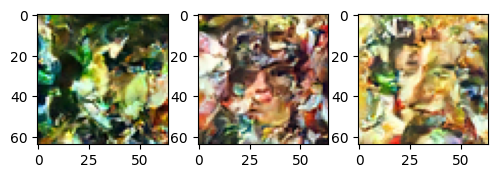

In [ ]:
columns = 5
rows = 5
fig = plt.figure(figsize=(10, 10), dpi=100)
sample_ = sample.permute(0, 2, 3, 1) # BxHxWxC
for i in range(0, sample_.shape[0]):
    s_ = decolor(s=sample_[i][..., :3], out_c='rgb')
    s_ = s_.detach().cpu().numpy()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(s_)

plt.show()
